<div class="alert alert-block alert-info">
<div class="text-center">
    <h2>Algorithmic  Machine Learning</h2><br>
    <h4>Challenge - Anomaly Detection</h4><br>
    <h4>Tristan NEMOZ | Thomas GENTILHOMME</h4>
    </div>
<br>
This Notebook contains the work of Thomas GENTILHOMME and Tristan NEMOZ about the Anomaly Detection challenge of the AML course (2019) of EURECOM. <br>

This challenge aims at detecting data points that do not conform with the rest of observations. <br> We have work on multi-label classifications,  where each check is a binary label corresponding to a specific type of anomaly. We have used 2 differents models : 
<ul>
     <li>The Bayesian Rule Set ;</li>
     <li>The Scalable Bayesian Rule List.</li>
    </ul>
</div>

-------------------------------------
<div class="">
    <h3>0. Notebook setup</h3>
</div>

<div class="">
    <h4>0.1. Loading bootstrap and MathJax</h3>
</div>

<div class="alert alert-block alert-info">
Loading bootstrap allows to display HTML directly in this notebook.
</div>

In [1]:
from IPython.display import HTML
html = '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/css/bootstrap.min.css">\n' + \
    '<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>\n' + \
    '<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/s/bootstrap.min.js"></script>\n' + \
    '<script src=’https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML’></script>'

display(HTML(html))  # Loading bootstrap

<div class="">
    <h4>0.2. Libraries</h3>
</div>

<div class="alert alert-block alert-info">
Importing useful libraries for this Notebook.
</div>

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import f1_score

<div class="">
    <h4>0.3. Progress bar</h3>
</div>

<div class="alert alert-block alert-info">
Defining an HTML progress bar to have running information for the longest executions.
</div>

In [3]:
from IPython.display import clear_output, HTML

class ProgressBar:
    def __init__(self, max_progress, bar_length=100):
        self.__progress = 0
        self.__max_progress = max_progress
        self.__bar_length = bar_length
    
    def start(self):
        self.__beginning_time = time()
        self.__mean_speeds = []
    
    def update(self):
        self.__progress += 1
        progress = self.__bar_length * float(self.__progress) / self.__max_progress
        blocks = int(progress)
        dashes = self.__bar_length - blocks
        clear_output(wait=True)
        elapsed_time = time() - self.__beginning_time
        mean_speed = self.__progress / elapsed_time
        self.__mean_speeds.append(mean_speed)
        total_time = self.__max_progress * elapsed_time / self.__progress
        html = '<div class="progress">\n'
        html += '\t<div class="progress-bar" role="progressbar" style="width: {0}%" aria-valuenow="{0}" aria-valuemin="0" aria-valuemax="{1}">'.format(progress, self.__max_progress)
        html += '\n\t<span>{0:.2f}%\t({1:.1f}/{2:.1f} seconds)</span>\n\t</div>\n'.format(progress, elapsed_time, total_time)
        html += '\n</div>'
        display(HTML(html))
        
    def plot_results(self):
        progresses = np.arange(len(self.__mean_speeds))
        plt.figure(figsize=(28, 7))
        plt.plot(progresses, self.__mean_speeds)
        plt.title("Mean speed of the function over time")
        plt.xlabel("Number of treated images")
        plt.ylabel("Mean speed (in images/second)")
        plt.show()

css_custom = '<style>.progress {\n' + \
    '\tposition: relative;\n' + \
'}\n\n' + \
'.progress span {\n' + \
    '\tposition: absolute;\n' + \
    '\tdisplay: block;\n' + \
    '\twidth: 100%;\n' + \
    '\tcolor: black;\n' + \
    '\tfont-weight: bold;' + \
'}</style>'

display(HTML(css_custom))

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

Data exploration is also useful to identify eventual errors in the dataset: for example, some features may have values that are outside the allowed range of values. Ranges are specified in the dataset description.

<div class="alert alert-block alert-info">
First, we load the data and we split the features and the labels into 2 Dataframes. In order to know with what data we are working with, we rename the columns with their real name.
</div>

In [4]:
base = "/mnt/datasets/anomaly/"

dataset = pd.read_csv(base + "data.csv",
                      sep=';',
                      header=None,
                      names=["SessionNumber", "SystemID", "Date", "HighPriorityAlerts", "Dumps", "CleanupOOMDumps", "CompositeOOMDums", 
                              "IndexServerRestarts", "NameServerRestarts", "XSEngineRestarts", "PreprocessorRestarts", "DaemonRestarts", 
                              "StatisticsServerRestarts", "CPU", "PhysMEM",  "InstanceMEM", "TablesAllocation", "IndexServerAllocationLimit",
                              "ColumnUnloads", "DeltaSize", "MergeErrors", "BlockingPhaseSec", "Disk", "LargestTableSize", "LargestPartitionSize",
                              "DiagnosisFiles", "DiagnosisFilesSize", "DaysWithSuccessfulDataBackups", "DaysWithSuccessfulLogBackups",
                              "DaysWithFailedDataBackups", "DaysWithFailedfulLogBackups", "MinDailyNumberOfSuccessfulDataBackups",
                              "MinDailyNumberOfSuccessfulLogBackups", "MaxDailyNumberOfFailedDataBackups", "MaxDailyNumberOfFailedLogBackups", 
                              "LogSegmentChange", "Check1", "Check2", "Check3", "Check4", "Check5", "Check6", "Check7", "Check8"],
                      parse_dates=['Date'],
                      date_parser=lambda date: pd.to_datetime(date, infer_datetime_format=True)
)

features = pd.DataFrame()
labels = pd.DataFrame()

features = dataset.iloc[: , 0:36]
labels = dataset.iloc[: , 36:]

display(features[:5])
display(labels[:5])

LENGTH=dataset['SessionNumber'].count()

,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,DiagnosisFilesSize,DaysWithSuccessfulDataBackups,DaysWithSuccessfulLogBackups,DaysWithFailedDataBackups,DaysWithFailedfulLogBackups,MinDailyNumberOfSuccessfulDataBackups,MinDailyNumberOfSuccessfulLogBackups,MaxDailyNumberOfFailedDataBackups,MaxDailyNumberOfFailedLogBackups,LogSegmentChange
0,0,0,2017-01-16 04:04:00,1,0.0,0.0,0.0,0,0,0,...,444366335.0,7,8,0,0,1,32,0,0,0.0
1,1,1,2017-02-06 04:03:00,0,0.0,0.0,0.0,0,0,0,...,227400051.0,3,8,0,0,1,32,0,0,0.0
2,2,1,2017-02-20 04:03:00,0,0.0,0.0,0.0,0,0,0,...,234913753.0,3,8,0,0,1,32,0,0,0.0
3,3,2,2017-02-13 04:44:00,1,0.0,0.0,0.0,0,0,0,...,511053878.0,7,8,0,0,1,38,0,0,0.0
4,4,3,2017-02-06 04:31:00,1,0.0,0.0,0.0,0,0,0,...,172953445.0,7,8,0,0,1,5,0,0,0.0


,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


<div class="alert alert-block alert-info">
Visualisation of some datas
</div>

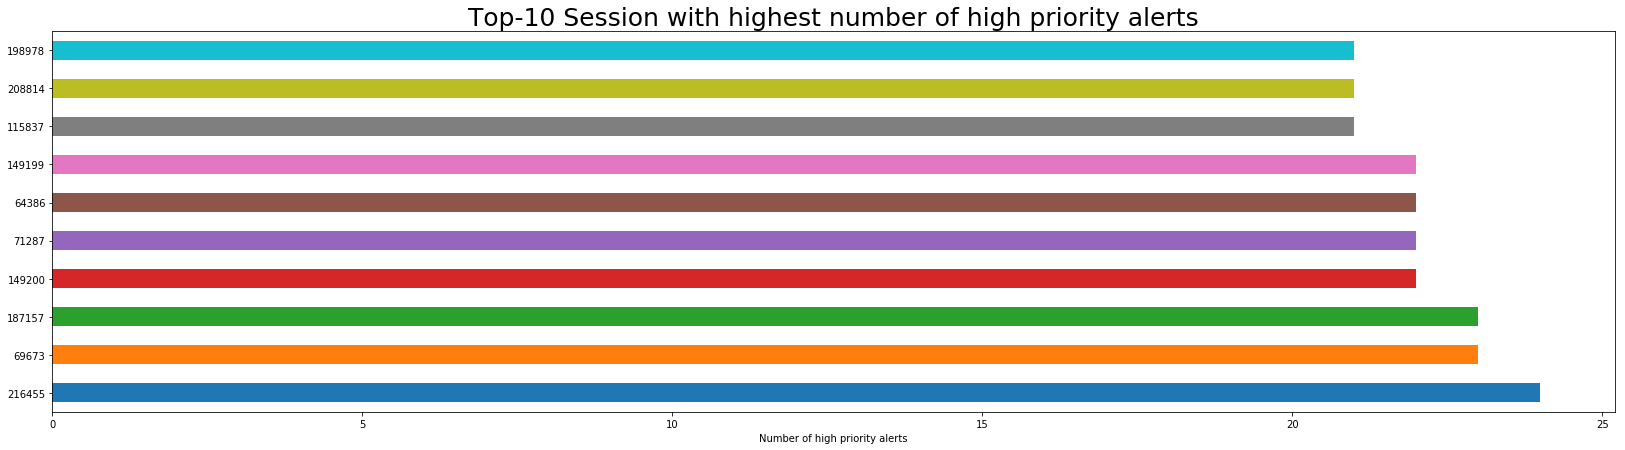

In [5]:
## HIGH PRIORITY ALERTS
topN = 10
high_priority_alerts_sessions = features[['SessionNumber','HighPriorityAlerts']].sort_values('HighPriorityAlerts',ascending=False)[:topN]

fig, ax = plt.subplots(figsize=(28, 7))
high_priority_alerts_sessions['HighPriorityAlerts'].plot(kind='barh', ax=ax)
ax.set_xlabel('Number of high priority alerts')
ax.set_yticklabels(high_priority_alerts_sessions['SessionNumber'])
ax.set_title('Top-10 Session with highest number of high priority alerts', fontsize=25)

plt.show()
html = " <div class='alert alert-block alert-success'> " + \
"Average number of high priority alerts per data : <b>{0:.2f}</b>".format(features['HighPriorityAlerts'].mean()) + \
"</div> "
display(HTML(html))

<div class="alert alert-block alert-info">
    Let's see what is the proportion of session with 8 <i>NaN</i> checks. These sessions don't carry anny information as they are not labelized.
</div>

In [6]:
count_na=len(labels[labels[['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']].isna().all(axis=1)])
html = " <div class='alert alert-block alert-success'> " + \
"The proportion of session with 8 NaNs Checks is : <b>{0:.2f}%</b>".format(count_na/len(dataset[['SessionNumber']].values)*100) + \
". It corresponds to <b>" + str(count_na) + "</b> sessions that are not at all labelized." + "</div> "
display(HTML(html))

<div class="alert alert-block alert-info">
    Let's see the proportion of <i>0</i>, <i>1</i> and <i>NaNs</i> in the different labels:
</div>

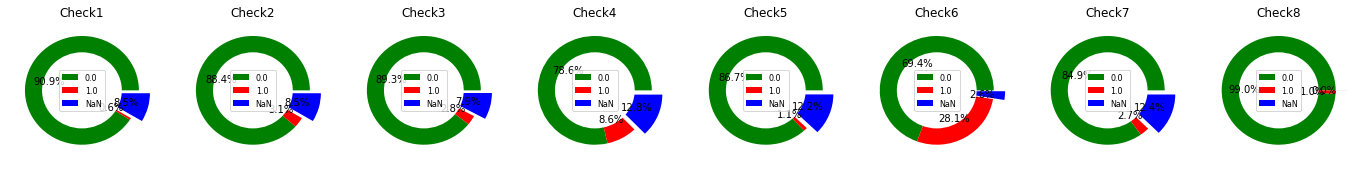

In [7]:
total=len(labels['Check1'].values)

fig = plt.figure(figsize=(24,2.5))

for i in range(1,9):
    labels_grouped=labels.groupby('Check'+str(i), as_index=False).size().reset_index().rename(columns={0:'Number'})
    labels_grouped = labels_grouped.append({'Check'+str(i) : 'NaN' , 'Number' : total-labels_grouped['Number'].values.sum()}, ignore_index=True)
    
    explode = [0] * len(labels_grouped)
    nan_index = labels_grouped[labels_grouped['Check'+str(i)] == 'NaN'].index[0]
    explode[nan_index] = 0.2
    ax1 = plt.subplot2grid((1,8), (0, i-1))
    plt.pie(labels_grouped.Number ,colors=("g","r","b"), explode=explode, autopct='%1.1f%%')
    plt.title('Check'+str(i))
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    plt.legend(labels_grouped['Check'+str(i)], loc='center', fontsize=8)
    fig.gca().add_artist(centre_circle)

plt.show()

<div class="alert alert-block alert-success">
What is interesting here is that some checks, like 6 and 4, are "often" called so we can assumed that they are lined to "low level anomalies" whereas checks 1, 5 and 6 are probably linked to "high level anomalies". Also, we can see that check 8 doesn't own (or very few) <i>NaN</i> values so we can assumed that every sessions is concerned by check8.
</div>

<div class="alert alert-block alert-info">
    We can have more detailed information by displaying the number of <i>NaNs</i> in the labels:
</div>

In [8]:
count_nans = pd.DataFrame(columns=['Series', 'NaNs number'])

for column in labels:
    counter = {'Series': column}
    counter['NaNs number'] = labels[column].isna().sum()
    count_nans = count_nans.append(counter, ignore_index=True)

display(count_nans)

,Series,NaNs number
0,Check1,24511
1,Check2,24486
2,Check3,22568
3,Check4,36647
4,Check5,35034
5,Check6,7384
6,Check7,35722
7,Check8,52


<div class="alert alert-block alert-info">
    Let's see what is the proportion of sessions who own a <i>NaN</i>:
</div>

In [9]:
nb_nans=features.dropna()['SessionNumber'].count()
prop_nans=(nb_nans/features['SessionNumber'].count())*100
html = " <div class='alert alert-block alert-success'> " + \
"The proportion of session with <i>NaN(s)</i> in his features is : <b>{0:.2f}%</b>".format(prop_nans) + \
"</div> "
display(HTML(html))

<div class="alert alert-block alert-info">
    We can have more detailed information by displaying the number of <i>NaNs</i> in each features:
</div>

In [10]:
count_nans = pd.DataFrame(columns=['Series', 'NaNs number'])

for column in features:
    counter = {'Series': column}
    counter['NaNs number'] = features[column].isna().sum()
    count_nans = count_nans.append(counter, ignore_index=True)

display(count_nans)

,Series,NaNs number
0,SessionNumber,0
1,SystemID,0
2,Date,0
3,HighPriorityAlerts,0
4,Dumps,3
5,CleanupOOMDumps,3
6,CompositeOOMDums,3
7,IndexServerRestarts,0
8,NameServerRestarts,0
9,XSEngineRestarts,0


<div class="alert alert-block alert-info">
    We can see that 17 features, which is almost a half of the total number of features, own <i>NaN</i> values.
</div>

<div class="alert alert-block alert-info">
Now, we can display the 4 most correlated features with each labels.
</div>

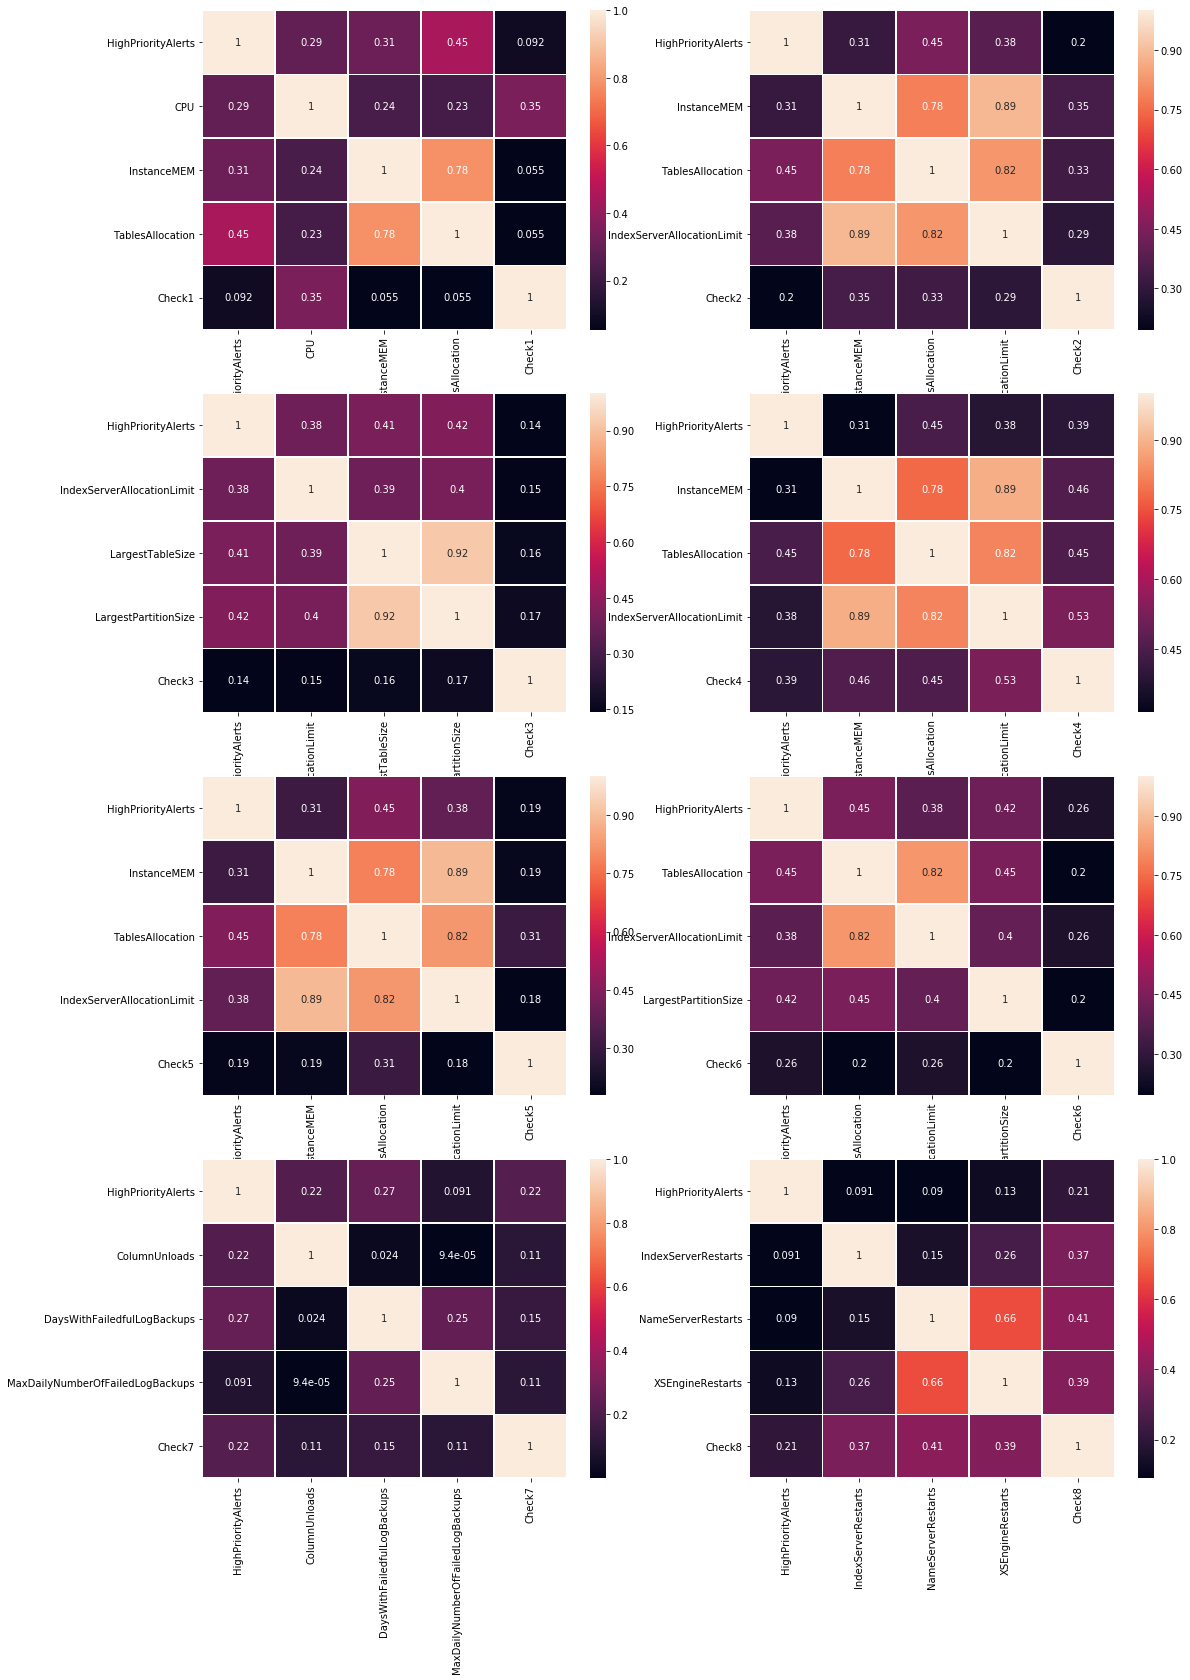

In [11]:
total=len(labels['Check1'].values)

fig = plt.figure(figsize=(18, 27))


for i in range(1, 9):
    corr_features = features.copy(deep=True)
    
    corr_features.drop(['Date'], axis=1, inplace=True)
    corr_features.drop(['CleanupOOMDumps'], axis=1, inplace=True)
    corr_features.drop(['PreprocessorRestarts'], axis=1, inplace=True)
    corr_features.drop(['DaemonRestarts'], axis=1, inplace=True)
        #because Date is a string and the 3 others names are series of zeros only
    corrs_dict = {}
    corrs = []
    for names in list(corr_features)[:]:

        corr = labels['Check'+str(i)].corr(corr_features[names])
        corrs.append(np.abs(corr))
        corrs_dict[np.abs(corr)]=names

        '''
        if np.abs(corr) < 0.4:
            corr_features.drop([names], axis=1, inplace=True)
        '''
    corrs.sort()
    col1=corrs_dict[corrs[-4]]
    col2=corrs_dict[corrs[-3]]
    col3=corrs_dict[corrs[-2]]
    col4=corrs_dict[corrs[-1]]

    for names in list(corr_features)[:]:
        if names != col1 and names != col2 and names != col3 and names != col4:
            corr_features.drop([names], axis=1, inplace=True)  # To keep only the 4 columns with the highest correlations
    
    corr_features['Check'+str(i)] = labels['Check'+str(i)]
    
    corr = corr_features.corr()
    plt.subplot(4, 2, i)
    sns.heatmap(corr, annot=True, linewidth=.5)
    
plt.show()

<div class="alert alert-block alert-success">
We can see above that there are not clear and huge correlations between the labels and the features. Nevertheless, we can see that there are some interesting correlations betwenn Check4 and <b>HighPriorityAlerts</b>, <b>InstanceMEM</b>, <b>TablesAllocation</b>, <b>IndexServerAllocationLimit</b>.
</div>


<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection;
- Handling missing information in the dataset;
- Handling errors in the dataset;
- Combining existing features.

<div class="alert alert-block alert-info">
    <h3>Handling missing information in the dataset</h3>
</div>
<div class="alert alert-block alert-info">
    In this dataset, we have 3 columns with that are series of zero and the <b>Date</b> feature that doesn't give any interesting information.
</div>

In [12]:
dataset.drop(['Date'], axis=1, inplace=True)
dataset.drop(['CleanupOOMDumps'], axis=1, inplace=True)
dataset.drop(['PreprocessorRestarts'], axis=1, inplace=True)
dataset.drop(['DaemonRestarts'], axis=1, inplace=True)

<div class="alert alert-block alert-info">
    In this dataset, there are also a lot of <i>NaN</i> values that we have to deal with. As we have seen in the 1st part, almost <b>70%</b> of the dataset has a <i>NaN</i> value so we can't simply remove them. In the same way, we have seen that almost a half of the features own <i>NaN</i> values, so we can't simply remove them either, all the more that some of them are "highly" correlated with Chech4. <br><br>
    <b>So what an we do? </b>We can star by looking if there is zero-values in the features columns containing a lot of <i>NaNs</i>. If not, we can say that we replace <i>NaNs</i> with <i>zeros</i> in those columns.
</div>

### CPU: 25209 $NaNs$

In [13]:
count = 0
for cpu in dataset['CPU'].values:
    if cpu == 0 :
        count+=1
print('Number of zeros in CPU column: ', count)

Number of zeros in CPU column:  0


### PhysMEM: 20567 $NaNs$

In [14]:
count = 0
for pmem in dataset['PhysMEM'].values:
    if pmem == 0 :
        count+=1
print('Number of zeros in PhysMEM column: ', count)

Number of zeros in PhysMEM column:  0


### InstanceMEM: 22117 $NaNs$

In [15]:
count = 0
for imem in dataset['InstanceMEM'].values:
    if imem == 0 :
        count+=1
print('Number of zeros in InstanceMEM column: ', count)

Number of zeros in InstanceMEM column:  0


### TablesAllocation: 2290 $NaNs$

In [16]:
count = 0
for ta in dataset['TablesAllocation'].values:
    if ta == 0 :
        count+=1
print('Number of zeros in TablesAllocation column: ', count)

Number of zeros in TablesAllocation column:  25986


### IndexServerAllocationLimit: 26444 $NaNs$

In [17]:
count = 0
for isal in dataset['IndexServerAllocationLimit'].values:
    if isal == 0 :
        count+=1
print('Number of zeros in IndexServerAllocationLimit column: ',count)

Number of zeros in IndexServerAllocationLimit column:  0


### DeltaSize: 206 $NaNs$

In [18]:
count = 0
for ds in dataset['DeltaSize'].values:
    if ds == 0 :
        count+=1
print('Number of zeros in DeltaSize column: ',count)

Number of zeros in DeltaSize column:  354


### MergeErrors: 7733 $NaNs$

In [19]:
count = 0
for me in dataset['MergeErrors'].values:
    if me == 0 :
        count+=1
print('Number of zeros in MergeErrors column: ',count)

Number of zeros in MergeErrors column:  162979


### BlockingPhaseSec: 75854 $NaNs$

In [20]:
count = 0
for bps in dataset['BlockingPhaseSec'].values:
    if bps == 0 :
        count+=1
print('Number of zeros in BlockingPhaseSec column: ',count)

Number of zeros in BlockingPhaseSec column:  3675


### Disk: 11379 $NaNs$

In [21]:
count = 0
for disk in dataset['Disk'].values:
    if disk == 0 :
        count+=1
print('Number of zeros in Disk column: ',count)

Number of zeros in Disk column:  0


### LargestTableSize: 16250 $NaNs$

In [22]:
count = 0
for lts in dataset['LargestTableSize'].values:
    if lts == 0 :
        count+=1
print('Number of zeros in LargestTableSize column: ',count)

Number of zeros in LargestTableSize column:  317


### LargestPartitionSize: 150 $NaNs$

In [23]:
count = 0
for lps in dataset['LargestPartitionSize'].values:
    if lps == 0 :
        count+=1
print('Number of zeros in LargestPartitionSize column: ',count)

Number of zeros in LargestPartitionSize column:  385


### DiagnosisFiles: 21923 $NaNs$

In [24]:
count = 0
for df in dataset['DiagnosisFiles'].values:
    if df == 0 :
        count+=1
print('Number of zeros in DiagnosisFiles column: ',count)

Number of zeros in DiagnosisFiles column:  0


### DiagnosisFilesSize: 21923 $NaNs$

In [25]:
count = 0
for dfs in dataset['DiagnosisFilesSize'].values:
    if dfs == 0 :
        count+=1
print('Number of zeros in DiagnosisFilesSize column: ',count)

Number of zeros in DiagnosisFilesSize column:  0


### LogSegmentChange: 35549 $NaNs$

In [26]:
count = 0
for lsc in dataset['LogSegmentChange'].values:
    if lsc == 0 :
        count+=1
print('Number of zeros in LogSegmentChange column: ',count)

Number of zeros in LogSegmentChange column:  227058


### Dumps: 3 $NaNs$

In [27]:
count = 0
for dumps in dataset['Dumps'].values:
    if dumps == 0 :
        count+=1
print('Number of zeros in Dumps column: ',count)

Number of zeros in Dumps column:  259009


### CompositeOOMDums: 3 $NaNs$

In [28]:
count = 0
for dfs in dataset['CompositeOOMDums'].values:
    if dfs == 0 :
        count+=1
print('Number of zeros in CompositeOOMDums column: ',count)

Number of zeros in CompositeOOMDums column:  272202


<div class="alert alert-block alert-success">
    Over the 16 series containing <i>NaNs</i> (16 because we have removed CleanupOMMDumps), 7 have no zero-value. We can replace them. Among the 9 remaining series, 6 have very few <i>NaNs</i>. We can remove the corresponding rows. It will leave 3 columns to deal with.
</div>

In [29]:
dataset['CPU'].fillna(0,inplace=True)
dataset['PhysMEM'].fillna(0,inplace=True)
dataset['InstanceMEM'].fillna(0,inplace=True)
dataset['IndexServerAllocationLimit'].fillna(0,inplace=True)
dataset['Disk'].fillna(0,inplace=True)
dataset['DiagnosisFiles'].fillna(0,inplace=True)
dataset['DiagnosisFilesSize'].fillna(0,inplace=True)

names = ['CompositeOOMDums', 'Dumps', 'LargestPartitionSize', 'MergeErrors', 'DeltaSize', 'TablesAllocation']
for name in names:
    dataset.dropna(axis=0, subset=names, inplace=True)
dataset.reset_index(inplace=True)

prop_del=100-(dataset['SessionNumber'].count()/LENGTH)*100
html = " <div class='alert alert-block alert-success'> " + \
"The proportion of rows that has been deleted is: <b>{0:.2f}%</b>".format(prop_del) + \
"</div> "
display(HTML(html))

<div class="alert alert-block alert-info">
    So there are 3 columns left containing <i>NaNs</i>: <b>BlockingPhaseSec</b>, <b>LargestTableSize</b> and <b>LogSegmentChange</b>. First, we can try to use 'dropna', as above, and see what is the new proprotion of rows that have been deleted:
</div>

In [30]:
dropna_set=dataset.copy(deep=True)
dropna_set.dropna(axis=0, subset=['BlockingPhaseSec', 'LargestTableSize', 'LogSegmentChange'], inplace=True)
prop_del=100-(dropna_set['SessionNumber'].count()/LENGTH)*100
html = " <div class='alert alert-block alert-success'> " + \
"The proportion of rows that has been deleted is: <b>{0:.2f}%</b>".format(prop_del) + \
"</div> "
display(HTML(html))
del dropna_set

<div class="alert alert-block alert-info">
    This proportion is too huge! We can't create validation and test sets and still have a large enough train set to train our models. What we can try is looking the correlation of those 3 columns with the 8 labels to know if we can simply delete them or not.
</div>

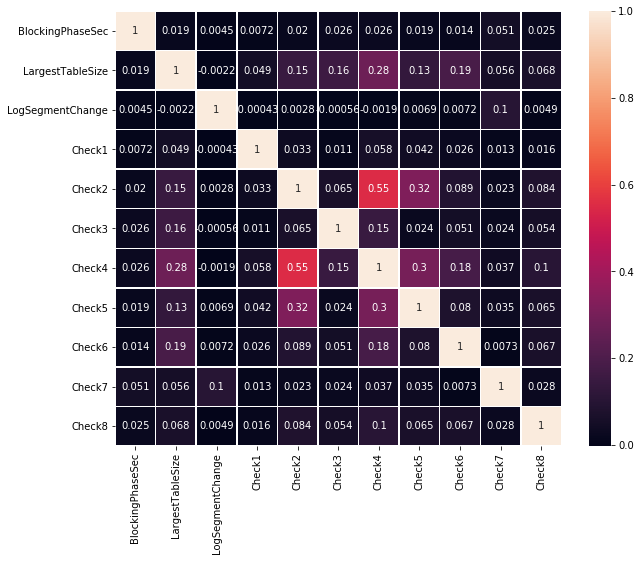

In [31]:
dropcol_set=dataset[['BlockingPhaseSec', 'LargestTableSize', 'LogSegmentChange', 'Check1','Check2', 'Check3', 'Check4', 'Check5', 'Check6',
                     'Check7', 'Check8']]
corr = dropcol_set.corr()
#to_plot = corr.values.copy()
#for i in range(to_plot.shape[0]):
#    to_plot[i,i] = 0
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True, linewidth=.5, ax=ax)
del dropcol_set

<div class="alert alert-block alert-success">
    We can see that we can clearly drop <b>BlockingPhaseSec</b> and <b>LogSegmentChange</b>. However, we can see that <b>LargestTableSize</b> has higher correlation values with some labels.
</div>

<div class="alert alert-block alert-info">
    After dropping the 2 mentionned columns, let's try to see what is the proportion of remaining rows if we do a 'dropna' on the <b>LargestTableSize</b> column.
</div>

In [32]:
dataset.drop(['BlockingPhaseSec', 'LogSegmentChange'], axis=1, inplace=True)
dropna_set=dataset.copy(deep=True)
dropna_set.dropna(axis=0, subset=['LargestTableSize'], inplace=True)
prop_del=100-(dropna_set['SessionNumber'].count()/LENGTH)*100
html = " <div class='alert alert-block alert-success'> " + \
"The proportion of rows that has been deleted is: <b>{0:.2f}%</b>".format(prop_del) + \
"</div> "
display(HTML(html))
del dropna_set

<div class="alert alert-block alert-info">
This is an acceptable proportion. Now let's do it on the dataset, seperate features and labels and check that we have no remaining <i>NaNs</i>.
</div>

In [33]:
dataset.dropna(axis=0, subset=['LargestTableSize'], inplace=True)

features = pd.DataFrame()
labels = pd.DataFrame()

features = dataset.iloc[: , 0:31]
labels = dataset.iloc[: , 31:]

In [34]:
count_nans = pd.DataFrame(columns=['Series', 'NaNs number'])

for column in features:
    counter = {'Series': column}
    counter['NaNs number'] = features[column].isna().sum()
    count_nans = count_nans.append(counter, ignore_index=True)

display(count_nans)

,Series,NaNs number
0,index,0
1,SessionNumber,0
2,SystemID,0
3,HighPriorityAlerts,0
4,Dumps,0
5,CompositeOOMDums,0
6,IndexServerRestarts,0
7,NameServerRestarts,0
8,XSEngineRestarts,0
9,StatisticsServerRestarts,0


<div class="alert alert-block alert-info">
<h3>Concerning the outliers</h3>
Since the data we have come from computers reports, we have a fair chance that we wont have any outliers in the dataset. More important, the presence of outliers has only a little impact on the predictions we want to make, since we are trying to classify things, rather than predicting a number, like we would have done in a regression problem. Hence, the impact the outliers could have had will be, according to us, compensated with the fact that we round the prediction of the model, since we are only predicting a binary number.
</div>

<div class="alert alert-block alert-info">
    <h3> Concerning data normalisation </h3>
    We do not think that the data need to be normalised. Indeed, the models we will work with are Bayesian ones. Hence, they use the Bayes formula, among other things, to make their predictions. Normalizing the data would make us taking the risk of adding some kind of bias to the data. Finally, the model we have decided to use, the Bayesian Rule Set one, already apply a data normalization (with the normalize method of the model class). For these reasons, we have decided not to apply a standardisation of the data.
</div>

<div class="alert alert-block alert-info">
    <h3>Combining existing labels</h3>
</div>
<div class="alert alert-block alert-info">
    We can try to build new labels by combining one or more labels (for example by doing an OR) and then check if this impacts the performance of the model(s).<br><br>
 <ul>
    <li>For instance, we notice that Check4 and Check2 are highly corrolated. This probabbly means that they often occur in the same sonditions. Studying them together migth me a good idea so we create <b>Check9 = Check2 OR Check4</b>.<br> In order to handle cases where there are $NaNs$, we will consider there intersection as zeros.</li><br>
    <li>Futhermore, we can also create <b>Check10</b> by combining all checks : $\mathbf{check_{10} = \bigcup\limits_{n=1}^{8}check_n}$. In order to handle cases where there are $NaNs$, we will consider these unions as zeros.</li>
</ul>
</div>

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8,Check9,Check10
0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0,0


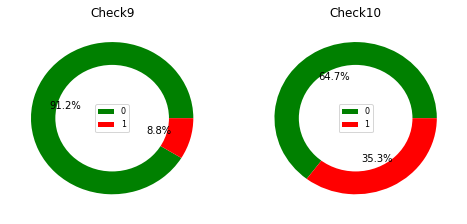

In [35]:
labels_copy = labels.copy()
labels_copy = labels_copy.fillna(0)


check9 =  labels_copy.Check2.astype(int) | labels_copy.Check4.astype(int) 
labels['Check9'] = check9
dataset['Check9'] = check9

check10 = labels_copy.Check1.astype(int) | labels_copy.Check2.astype(int) | labels_copy.Check3.astype(int) | labels_copy.Check4.astype(int) | labels_copy.Check5.astype(int) | labels_copy.Check6.astype(int) | labels_copy.Check7.astype(int) | labels_copy.Check8.astype(int)
labels['Check10'] = check10
dataset['Check10'] = check10

display(labels.head(5))

total=len(labels['Check1'].values)

fig = plt.figure(figsize=(8,3.5))

labels_grouped=labels.groupby('Check9', as_index=False).size().reset_index().rename(columns={0:'Number'})
ax1 = plt.subplot2grid((1,2), (0, 0))
plt.pie(labels_grouped.Number ,colors=("g","r"), autopct='%1.1f%%')
plt.title('Check9')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
plt.legend(labels_grouped['Check9'], loc='center', fontsize=8)
fig.gca().add_artist(centre_circle)

labels_grouped=labels.groupby('Check10', as_index=False).size().reset_index().rename(columns={0:'Number'})
ax1 = plt.subplot2grid((1,2), (0, 1))
plt.pie(labels_grouped.Number ,colors=("g","r"), autopct='%1.1f%%')
plt.title('Check10')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
plt.legend(labels_grouped['Check10'], loc='center', fontsize=8)
fig.gca().add_artist(centre_circle)

plt.show()

del labels_grouped
del labels_copy

<div class="">
    <h3>3. Model Selection</h3>
</div>

At this point, you should have a good understanding of the dataset, and have an idea about the possible candidate models. For example, you may try a multi-label classification model to predict all classes at ones, or train different models, one for each label. In any case, it is important to justify your choices and make a comparison among the candidate models.

You are free to choose any model you want, but you should be aware about some factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model able to handle imbalanced datasets?
- Is the model capable of handling both numerical and categorical data?
- Is the model able to handle missing values?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade. You may also try to build new labels by combining one or more labels (for example by doing an OR) and check if this impacts the performance of the model(s).

<div class="">
    <h4>3.1 Interpretable Models</h3>
</div>

Being able to understand the output of a model is important in many field, especially in anomaly detection. In linear regression, for example, the weights of the model can provide some hints on the importance of features, and this is a form of interpretability. Here, we focus on Rule learning, a specific field of interpretable machine learning that provides interpretability through the use of rules. Examples of rule-based models are: 

- RIPPER
    - [Main Paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.107.2612&rep=rep1&type=pdf)
    - A fast and reliable implementation is JRIP by [WEKA](https://www.cs.waikato.ac.nz/~ml/weka/). You can also find unofficial python implementations on GitHub.
- Bayesian Rule Sets (BRS)
    - [Main Paper](http://jmlr.org/papers/volume18/16-003/16-003.pdf)
    - You can find a good implementation [here](https://pypi.org/project/ruleset/). You will probably need to install "fim" (pip install fim) before installing BRS.
- Scalable Bayesian Rule Lists (SBRL)
    - [Main Paper](https://arxiv.org/pdf/1602.08610.pdf)
    - You can find a good implementation [here](https://github.com/myaooo/pysbrl). You will probably need to install "fim" (pip install fim) before installing SBRL.
- and so on... 

Try to run at least one of the suggested models (you are free to try others as well) and comment:

- Are rule-learning models able to provide the same predictive performances as previously tested models?
- Are they faster or slower to train?
- Do learned rules look meaningful to you?
- How many rules do these models learn?
- How many conditions/atoms have on average?

<b>N.B.</b> Since most of the rule-learning implementations deal with binary labels, you can train the model to predict one label of your choice.

<div class="alert alert-block alert-info">
 <h3>Bayesian Rule Sets (BRS) model</h3>
</div>

In [46]:
!pip install 'ruleset' --user --upgrade

  Stored in directory: /mnt/workspace/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<div class="alert alert-block alert-info">
    What we want to do first is to try to evaluate the model with its default parameters.
</div>

<div class="alert alert-block alert-info">
 <h5>Check 1</h5>
</div>

In [3]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//2

dataset1 = dataset[:subset_size].copy(deep=True)
dataset1.dropna(axis=0, subset=['Check1'], inplace=True)
features1 = pd.DataFrame()
labels1 = pd.DataFrame()

features1 = dataset1.iloc[: , 0:31]
labels1 = dataset1.iloc[: , 31:]

X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, labels1['Check1'], test_size=0.9)

BRS_model_1 = ruleset.BayesianRuleSet(method='forest')
BRS_model_1.fit(X_train1, y_train1.astype('int64').values)

y_pred1 = BRS_model_1.predict(X_test1)
f1_score_1 = f1_score(y_test1, y_pred1, average='macro')
print('F1_score = ',f1_score_1)
del dataset1
del features1
del labels1


** chain = 1, max at iter = 0 ** 
 accuracy = 0.993370607028754, TP = 0,FP = 0, TN = 12437, FN = 83
 old is -999999999.9, pt_new is -518.9188054178328, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -501.44006049833365
 
[]
F1_score =  0.49840417718307223


<div class="alert alert-block alert-info">
 <h5>Check 2</h5>
</div>

In [40]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//2

dataset2 = dataset[:subset_size].copy(deep=True)
dataset2.dropna(axis=0, subset=['Check2'], inplace=True)
features2 = pd.DataFrame()
labels2 = pd.DataFrame()

features2 = dataset2.iloc[: , 0:31]
labels2 = dataset2.iloc[: , 31:]

X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, labels2['Check2'], test_size=0.9)

BRS_model_2 = ruleset.BayesianRuleSet(method='forest')
BRS_model_2.fit(X_train2, y_train2.astype('int64').values)

y_pred2 = BRS_model_2.predict(X_test2)
f1_score_2 = f1_score(y_test2, y_pred2, average='macro')
print('F1_score = ',f1_score_2)
del dataset2
del features2
del labels2


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9641884313411312, TP = 0,FP = 0, TN = 12035, FN = 447
 old is -999999999.9, pt_new is -1949.135462003115, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -1931.6567170836158
 
[]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.9855792340970998, TP = 300,FP = 33, TN = 12002, FN = 147
 old is -1949.035462003115, pt_new is -930.542207256492, prior_ChsRules=-17.47874491949915, likelihood_1 = -115.41506543828177, likelihood_2 = -797.6483968987111
 
['90.03<=InstanceMEM', '6804.0<=LargestPartitionSize', 'InstanceMEM<95.64', 'LargestPartitionSize<2147474931.0', '161<=SystemID', 'SystemID<2470']
[717]

** chain = 1, max at iter = 2 ** 
 accuracy = 0.9955936548630028, TP = 442,FP = 50, TN = 11985, FN = 5
 old is -930.442207256492, pt_new is -251.49958459175468, prior_ChsRules=-34.23449247618555, likelihood_1 = -170.25819126567626, likelihood_2 = -47.00690084989287
 
['90.03<=InstanceMEM', '6804.0<=LargestPartitionSize', 'In

<div class="alert alert-block alert-info">
 <h5>Check 3</h5>
</div>

In [38]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//4

dataset3 = dataset[:subset_size].copy(deep=True)
dataset3.dropna(axis=0, subset=['Check3'], inplace=True)
features3 = pd.DataFrame()
labels3 = pd.DataFrame()

features3 = dataset3.iloc[: , 0:31]
labels3 = dataset3.iloc[: , 31:]

X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, labels3['Check3'], test_size=0.9)

BRS_model_3 = ruleset.BayesianRuleSet(method='forest')
BRS_model_3.fit(X_train3, y_train3.astype('int64').values)

y_pred3 = BRS_model_3.predict(X_test3)
f1_score_3 = f1_score(y_test3, y_pred3, average='macro')
print('F1_score = ',f1_score_3)
del dataset3
del features3
del labels3


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9861155957378108, TP = 79,FP = 0, TN = 6029, FN = 86
 old is -999999999.9, pt_new is -472.5508260948842, prior_ChsRules=-17.47874491949915, likelihood_1 = -0.5822156198527182, likelihood_2 = -454.48986555553233
 
['PhysMEM<99.36', '95.01<=PhysMEM', 'DiagnosisFilesSize<41074445010.0', '34827429.0<=DiagnosisFilesSize', 'InstanceMEM<68.6', '14.8<=InstanceMEM']
[643]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.9904746528898934, TP = 122,FP = 16, TN = 6013, FN = 43
 old is -472.4508260948842, pt_new is -349.01669615121284, prior_ChsRules=-34.23449247618555, likelihood_1 = -57.16646005859627, likelihood_2 = -257.615743616431
 
['PhysMEM<99.36', '95.01<=PhysMEM', 'DiagnosisFilesSize<41074445010.0', '34827429.0<=DiagnosisFilesSize', 'InstanceMEM<68.6', '14.8<=InstanceMEM']
['95.01<=PhysMEM', '70873651.0<=DeltaSize', '35060<=index', 'index<74720', 'PhysMEM<99.36']
[643, 1202]

** chain = 1, max at iter = 2 ** 
 accuracy = 0.9896674200839523,

<div class="alert alert-block alert-info">
 <h5>Check 4</h5>
</div>

In [82]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//4

dataset4 = dataset[:subset_size].copy(deep=True)
dataset4.dropna(axis=0, subset=['Check4'], inplace=True)
features4 = pd.DataFrame()
labels4 = pd.DataFrame()

features4 = dataset4.iloc[: , 0:31]
labels4 = dataset4.iloc[: , 31:]

X_train4, X_test4, y_train4, y_test4 = train_test_split(features4, labels4['Check4'], test_size=0.9)

BRS_model_4 = ruleset.BayesianRuleSet(method='forest')
BRS_model_4.fit(X_train4, y_train4.astype('int64').values)

y_pred4 = BRS_model_4.predict(X_test4)
f1_score_4 = f1_score(y_test4, y_pred4, average='macro')
print('F1_score = ',f1_score_4)
del dataset4
del features4
del labels4


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9349813748730105, TP = 191,FP = 30, TN = 5331, FN = 354
 old is -999999999.9, pt_new is -1447.725880483628, prior_ChsRules=-17.47874491949915, likelihood_1 = -98.15447867474904, likelihood_2 = -1332.09265688938
 
['86.97<=InstanceMEM', '123261689.0<=LargestPartitionSize', '0.0<=DiagnosisFiles', 'InstanceMEM<92.38', 'LargestPartitionSize<2147483645.0']
[351]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.9918726718591263, TP = 533,FP = 36, TN = 5325, FN = 12
 old is -1447.6258804836282, pt_new is -260.81554040112087, prior_ChsRules=-34.23449247618555, likelihood_1 = -139.37501443731776, likelihood_2 = -87.20603348761756
 
['86.97<=InstanceMEM', '123261689.0<=LargestPartitionSize', '0.0<=DiagnosisFiles', 'InstanceMEM<92.38', 'LargestPartitionSize<2147483645.0']
['90.02<=IndexServerAllocationLimit', '616<=index', '27080093.0<=LargestPartitionSize', 'IndexServerAllocationLimit<98.09', 'index<74766', 'LargestPartitionSize<2147483645.0']
[35

<div class="alert alert-block alert-info">
 <h5>Check 5</h5>
</div>

In [37]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//2

dataset5 = dataset[:subset_size].copy(deep=True)
dataset5.dropna(axis=0, subset=['Check5'], inplace=True)
features5 = pd.DataFrame()
labels5 = pd.DataFrame()

features5 = dataset5.iloc[: , 0:31]
labels5 = dataset5.iloc[: , 31:]

X_train5, X_test5, y_train5, y_test5 = train_test_split(features5, labels5['Check5'], test_size=0.9)

BRS_model_5 = ruleset.BayesianRuleSet(method='forest')
BRS_model_5.fit(X_train5, y_train5.astype('int64').values)

y_pred5 = BRS_model_5.predict(X_test5)
f1_score_5 = f1_score(y_test5, y_pred5, average='macro')
print('F1_score = ',f1_score_5)
del dataset5
del features5
del labels5


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9898964595858384, TP = 0,FP = 0, TN = 11855, FN = 121
 old is -999999999.9, pt_new is -696.3271091317972, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -678.8483642122981
 
[]
F1_score =  0.497255245815241


<div class="alert alert-block alert-info">
 <h5>Check 6</h5>
</div>

In [85]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//4

dataset6 = dataset[:subset_size].copy(deep=True)
dataset6.dropna(axis=0, subset=['Check6'], inplace=True)
features6 = pd.DataFrame()
labels6 = pd.DataFrame()

features6 = dataset6.iloc[: , 0:31]
labels6 = dataset6.iloc[: , 31:]

X_train6, X_test6, y_train6, y_test6 = train_test_split(features6, labels6['Check6'], test_size=0.9)

BRS_model_6 = ruleset.BayesianRuleSet(method='forest')
BRS_model_6.fit(X_train6, y_train6.astype('int64').values)

y_pred_6 = BRS_model_6.predict(X_test6)
f1_score_6 = f1_score(y_test6, y_pred_6, average='macro')
print('F1_score = ',f1_score_6)
del dataset6
del features6
del labels6

F1_score =  0.9590812976469789


<div class="alert alert-block alert-info">
 <h5>Check 7</h5>
</div>

In [38]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//2

dataset7 = dataset[:subset_size].copy(deep=True)
dataset7.dropna(axis=0, subset=['Check7'], inplace=True)
features7 = pd.DataFrame()
labels7 = pd.DataFrame()

features7 = dataset7.iloc[: , 0:31]
labels7 = dataset7.iloc[: , 31:]

X_train7, X_test7, y_train7, y_test7 = train_test_split(features7, labels7['Check7'], test_size=0.9)

BRS_model_7 = ruleset.BayesianRuleSet(method='forest')
BRS_model_7.fit(X_train7, y_train7.astype('int64').values)

y_pred7 = BRS_model_7.predict(X_test7)
f1_score_7 = f1_score(y_test7, y_pred7, average='macro')
print('F1_score = ',f1_score_7)
del dataset7
del features7
del labels7


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9731682146542827, TP = 0,FP = 0, TN = 12259, FN = 338
 old is -999999999.9, pt_new is -1577.5525718609958, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -1560.0738269414967
 
[]
F1_score =  0.4931399679015767


<div class="alert alert-block alert-info">
 <h5>Check 8</h5>
</div>

In [39]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//2

dataset8 = dataset[:subset_size].copy(deep=True)
dataset8.dropna(axis=0, subset=['Check8'], inplace=True)
features8 = pd.DataFrame()
labels8 = pd.DataFrame()

features8 = dataset8.iloc[: , 0:31]
labels8 = dataset8.iloc[: , 31:]

X_train8, X_test8, y_train8, y_test8 = train_test_split(features8, labels8['Check8'], test_size=0.9)

BRS_model_8 = ruleset.BayesianRuleSet(method='forest')
BRS_model_8.fit(X_train8, y_train8.astype('int64').values)

y_pred8 = BRS_model_8.predict(X_test8)
f1_score_8 = f1_score(y_test8, y_pred8, average='macro')
print('F1_score = ',f1_score_8)
del dataset8
del features8
del labels8


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9909137918297998, TP = 0,FP = 8, TN = 13414, FN = 115
 old is -999999999.9, pt_new is -705.5563102209214, prior_ChsRules=-13.70982264270424, likelihood_1 = -26.586969820607067, likelihood_2 = -665.2595177576102
 
['MinDailyNumberOfSuccessfulLogBackups<4701', '36.65<=CPU', 'CPU<76.32', '699<=MinDailyNumberOfSuccessfulLogBackups']
[728]

** chain = 1, max at iter = 79 ** 
 accuracy = 0.9915047647189186, TP = 0,FP = 0, TN = 13422, FN = 115
 old is -705.4563102209214, pt_new is -699.5623690915188, prior_ChsRules=-34.23449247618555, likelihood_1 = 0.0, likelihood_2 = -665.3278766153333
 
[]

** chain = 1, max at iter = 80 ** 
 accuracy = 0.9915047647189186, TP = 0,FP = 0, TN = 13422, FN = 115
 old is -699.4623690915188, pt_new is -682.8066215348324, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -665.3278766153333
 
[]
F1_score =  0.4975523855477336


<div class="alert alert-block alert-info">
 <h5>Check 9</h5>
</div>

In [38]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//4

dataset9 = dataset[:subset_size].copy(deep=True)
features9 = pd.DataFrame()
labels9 = pd.DataFrame()

features9 = dataset9.iloc[: , 0:31]
labels9 = dataset9.iloc[: , 31:]

X_train9, X_test9, y_train9, y_test9 = train_test_split(features9, labels9['Check9'], test_size=0.9)

BRS_model_9 = ruleset.BayesianRuleSet(method='forest')
BRS_model_9.fit(X_train9, y_train9.astype('int64').values)

y_pred9 = BRS_model_9.predict(X_test9)
f1_score_9 = f1_score(y_test9, y_pred9, average='macro')
print('F1_score = ',f1_score_9)
del dataset9
del features9
del labels9


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9196336238735412, TP = 0,FP = 0, TN = 6225, FN = 544
 old is -999999999.9, pt_new is -1918.953357963687, prior_ChsRules=-17.47874491949915, likelihood_1 = 0.0, likelihood_2 = -1901.474613044188
 
[]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.9859654306396809, TP = 511,FP = 62, TN = 6163, FN = 33
 old is -1918.8533579636871, pt_new is -430.92303944588866, prior_ChsRules=-17.47874491949915, likelihood_1 = -205.77242151783116, likelihood_2 = -207.67187300855835
 
['90.01<=IndexServerAllocationLimit', '1502065.0<=LargestPartitionSize', 'IndexServerAllocationLimit<98.36', 'LargestPartitionSize<2147483595.0', 'InstanceMEM<97.86', '40.14<=InstanceMEM']
[1222]

** chain = 1, max at iter = 4 ** 
 accuracy = 0.9920224553109765, TP = 497,FP = 7, TN = 6218, FN = 47
 old is -430.82303944588864, pt_new is -351.1119858654247, prior_ChsRules=-34.23449247618555, likelihood_1 = -38.05171134812758, likelihood_2 = -278.82578204111155
 
['90.01<=IndexS

<div class="alert alert-block alert-info">
 <h5>Check 10</h5>
</div>

In [36]:
import ruleset

warnings.filterwarnings("ignore")

subset_size = dataset.shape[0]//4

dataset10 = dataset[:subset_size].copy(deep=True)
features10 = pd.DataFrame()
labels10 = pd.DataFrame()

features10 = dataset10.iloc[: , 0:31]
labels10 = dataset10.iloc[: , 31:]

X_train10, X_test10, y_train10, y_test10 = train_test_split(features10, labels10['Check10'], test_size=0.9)

BRS_model_10 = ruleset.BayesianRuleSet(method='forest')
BRS_model_10.fit(X_train10, y_train10.astype('int64').values)

y_pred10 = BRS_model_10.predict(X_test10)
f1_score_10 = f1_score(y_test10, y_pred10, average='macro')
print('F1_score = ',f1_score_10)
del dataset10
del features10
del labels10


** chain = 1, max at iter = 0 ** 
 accuracy = 0.8116413059536121, TP = 966,FP = 4, TN = 4528, FN = 1271
 old is -999999999.9, pt_new is -3118.0059940208994, prior_ChsRules=-17.47874491949915, likelihood_1 = -27.084486697692, likelihood_2 = -3073.442762403708
 
['150.0<=DiagnosisFiles', '43.92<=IndexServerAllocationLimit', 'IndexServerAllocationLimit<96.12', '0<=HighPriorityAlerts']
[3052]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.8896439651351751, TP = 1506,FP = 16, TN = 4516, FN = 731
 old is -3117.9059940208995, pt_new is -2257.402075256119, prior_ChsRules=-34.23449247618555, likelihood_1 = -90.2928958263335, likelihood_2 = -2132.8746869536
 
['150.0<=DiagnosisFiles', '43.92<=IndexServerAllocationLimit', 'IndexServerAllocationLimit<96.12', '0<=HighPriorityAlerts']
['150.0<=DiagnosisFiles', '0.0<=DiagnosisFilesSize', 'TablesAllocation<54.13', '0.0<=TablesAllocation']
[3052, 654]

** chain = 1, max at iter = 3 ** 
 accuracy = 0.9157925838380854, TP = 1812,FP = 145, TN = 4387, F

<div class="alert alert-block alert-success">
 <h5>Results for the Bayesian Rule Set on each labels. As this is highly computable, we have trained the models on only a proportion of the dataset.</h5>
 </div>
 
|       Labels      |     Dataset Proportion     |     F1_score     |        
|-------------------|--------------------|------------------|
|       Check1      |        0.25        |      0.4983      |
|       Check1      |        0.5        |      0.9875     |        
|       Check2      |        0.25        |      0.4911      |
|       Check2      |        0.5        |      0.9710      |
|       Check3      |        0.25        |      0.9226      | 
|       Check4      |        0.25        |      0.9884      | 
|       Check5      |        0.25        |      0.4979      | 
|       Check5      |        0.5        |      0.4973      | 
|       Check6      |        0.25        |        0.9591       | 
|       Check7      |        0.25        |      0.4927      | 
|       Check7      |         0.5        |      0.4931      | 
|       Check8      |        0.25        |      0.4972      |
|       Check8      |        0.5        |      0.4975      | 
|       Check9      |        0.25        |      0.9576      | 
|       Check10     |        0.25        |        0.9034       | 
    


<div class="alert alert-block alert-success">
    We have to note that most of these results can be better. Indeed, because of the random initialization of the algorithm, it is possible that it stays stuck in a local minimum because of a bad initialization. Thus, what could have been done is to relaunch the algorithm for each of the check until he does a good initialization and keep this model for that check, but we have not done it for computational costs reasons.
</div>

<div class="alert alert-block alert-info">
 <h3>Scalable Bayesian Rule List (SBRL) model</h3>
</div>

In [47]:
!pip install 'pysbrl' --user --upgrade
!pip install 'mdlp.discretization' --user --upgrade

Requirement already up-to-date: pysbrl in /mnt/workspace/.local/lib/python3.5/site-packages (0.4.1)
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 194kB 1.4MB/s 
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
from pysbrl import BayesianRuleList
from sklearn.model_selection import train_test_split
from mdlp.discretization import MDLP

def compute_intervals(mdlp_discretizer):
    '''
    Implemented from the given documentation.
    '''
    category_names = []
    for i, cut_points in enumerate(mdlp_discretizer.cut_points_):
        idxs = np.arange(len(cut_points) + 1)
        names = mdlp_discretizer.assign_intervals(idxs, i)
        category_names.append(names)
        
    return category_names


def test_BayesianRuleList(data, check):
    """
    Train and test our model on a check.
    :return: f1_score
    """
    data.dropna(axis=0, subset=['Check'+str(check)], inplace=True)    
    data['Check'+str(check)]= data['Check'+str(check)].astype(int)
    
    feats = pd.DataFrame()
    labs = pd.DataFrame()
    feats = data.iloc[: , 0:31]
    labs = data.iloc[: , 31:]
    
    x, y = feats, labs['Check'+str(check)]
    feature_names = list(feats)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    discretizer = MDLP(random_state=42).fit(x_train, y_train)
    x_train_cat = discretizer.transform(x_train)
    x_test_cat = discretizer.transform(x_test)
    
    #train
    category_names = compute_intervals(discretizer)
    SBRL_model = BayesianRuleList(seed=1, feature_names=feature_names, category_names=category_names)
    SBRL_model.fit(x_train_cat, y_train)
    
    #print the scores
    print('scores for check', check)
    print('acc: {:.2f}%'.format(100*SBRL_model.score(x_test_cat, y_test)))
    y_pred = SBRL_model.predict(x_test_cat)
    f1 = f1_score(y_test, y_pred, average='macro')
    print('f1_score: {:.4f}'.format(f1))
    
    return(f1)

In [38]:
for i in range(9,11):
    score = test_BayesianRuleList(dataset, check=i)
    dico['check'+str(i)] = score

results = pd.DataFrame.from_dict(dico, orient='index', columns=['F1_score'])
display(results)

scores for check 1
acc: 99.96%
f1_score: 0.9847
scores for check 2
acc: 99.93%
f1_score: 0.9942
scores for check 3
acc: 99.69%
f1_score: 0.9739
scores for check 4
acc: 99.81%
f1_score: 0.9944
scores for check 5
acc: 99.92%
f1_score: 0.9825
scores for check 6
acc: 99.63%
f1_score: 0.9954
scores for check 7
acc: 97.05%
f1_score: 0.5247
scores for check 8
acc: 99.96%
f1_score: 0.9900
scores for check 9
acc: 99.60%
f1_score: 0.9877
scores for check 10
acc: 96.51%
f1_score: 0.9611


,F1_score
check6,0.995400
check5,0.982500
check4,0.994400
check3,0.973900
check2,0.994200
check10,0.961063
check1,0.984700
check7,0.524700
check9,0.987656
check8,0.990000


<div class="alert alert-block alert-success">
 <h5>Comparing the results on f1_score of the 2 models.</h5>
     </div>

|       Labels      |        f1 BRS        |       f1 SBRL      |        
|-------------------|----------------------|--------------------|
|       Check1      |        0.9875        |        0.9847      |        
|       Check2      |        0.9710        |        0.9942      |
|       Check3      |        0.9226        |        0.9739      | 
|       Check4      |        0.9884        |        0.9944      | 
|       Check5      |        0.4973        |        0.9825      | 
|       Check6      |        0.9591        |        0.9954      | 
|       Check7      |        0.4931        |        0.5247      | 
|       Check8      |        0.4975        |        0.9900      |
|       Check9      |        0.9576        |        0.9877      | 
|       Check10     |        0.9034        |        0.9611      | 

 
<div class="alert alert-block alert-success">
<h5>The Scalable Bayesian Rule List model is more accurate than the Bayesian Rule Set one. The obtained F1 score are greater, but we still have a low score for Check7.</h5>
 </div>

<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="alert alert-block alert-info">
 <h5>Let's explore the optimization of the parameters of the Bayesian Rule Set model.</h5>
    We can try to optimize 3 parameters: <b>max_rules</b>, <b>max_iter</b> and <b>maxlen</b>.
 </div>

In [2]:
from sklearn.model_selection import ParameterGrid
import ruleset

hyperparameters = {
    'max_rules': [1000, 5000],
    'max_iter': [50, 200],
    'maxlen': [3, 5]
}

resultsDF = pd.DataFrame(columns=['max_rules', 'max_iter', 'maxlen', 'F1 Score', 'Training time'])

already_done = [
    {
        'max_rules': 1000,
        'max_iter': 50,
        'maxlen': 3
    }
]

already_done_results = [
    (0.977172, 113.430339)
]

for i in range(len(already_done)):
    temp = already_done[i].copy()
    temp['F1 Score'] = already_done_results[i][0]
    temp['Training time'] = already_done_results[i][1]
    resultsDF = resultsDF.append(temp, ignore_index=True)

parameter_grid = list(ParameterGrid(hyperparameters))

subset_size = dataset.shape[0]//4

dataset1 = dataset.copy(deep=True)
dataset1.dropna(axis=0, subset=['Check1'], inplace=True)
labels1 = dataset1.iloc[:, 31:]
features1 = dataset1.iloc[:, 0:31]

X_train, X_test, y_train, y_test = train_test_split(features1, labels1['Check1'], test_size=0.5)

progress_bar = ProgressBar(len(parameter_grid))
progress_bar.start()

for parameter_combination in parameter_grid:
    if parameter_combination in already_done:
        progress_bar.update()
        continue
    BRS_model = ruleset.BayesianRuleSet(
        max_rules=parameter_combination['max_rules'],
        max_iter=parameter_combination['max_iter'],
        maxlen=parameter_combination['maxlen']
    )
    beginning_time = time()
    BRS_model.fit(X_train, y_train.astype('int64').values)
    y_pred = BRS_model.predict(X_test)
    ending_time = time() - beginning_time
    parameter_combination['Training time'] = ending_time
    parameter_combination['F1 Score'] = f1_score(y_test, y_pred, average='macro')
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    progress_bar.update()
    
    display(resultsDF.sort_values('F1 Score', ascending=False))

,max_rules,max_iter,maxlen,F1 Score,Training time
0,1000.0,50.0,3.0,0.977172,113.430339


<div class="alert alert-warning" role="alert">
    For a reason that we do not know, the kernel shuts down when trying to execute the second parameter combination. Nevertheless, we can observe that the model behaves well even when lowering its parameters. Thus, since it makes us gain computation time, what we want to do is to consider only the parameter combination <b>max_rules = 1000</b>, <b>ax_iter = 50</b> and <b>maxlen=3</b>.
</div>

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

<div class="alert alert-block alert-success">
    The 2 models are capables of dealing with all the dataset in a reasonnable amount of time. They behave well enough to consider the rules they create as at least a warning for the system administrator. Indeed, by monitoring the system to know when an alert is most-likely to come, the system administrator has more chances to prevent it or at least to identify more precisely its origin.
</div>